<a href="https://colab.research.google.com/github/Bast-94/CYBERML-Project/blob/data-set/cyber-ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for Cyber Security Project

In [1]:
import pandas as pd
import numpy as np
import os
import sys
from mlsecu.anomaly_detection_use_case import *
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Prepare Data

### Loading dataset

In [2]:
dataset_path = './data/SWaT.A3_dataset_Jul 19_labelled.xlsx'
df = pd.read_excel(dataset_path, header=1)

### Cleaning data

In order to work easier on our dataset we need to clean it properly.

In [3]:
full_df = df.drop([0])
full_df = full_df.reset_index(drop=True)
full_df = full_df.rename(columns={'GMT +0':'Date'})
full_df['Attack'] = full_df['Attack'].fillna('benign')
full_df['Label'] = full_df['Label'].fillna(0).astype(int)
full_df['Date'] = pd.to_datetime(full_df['Date'], format='ISO8601')
full_df.to_csv('./data/SWaT.A3_dataset_Jul_19_labelled.csv')
full_df.head()

,Date,Attack,Label,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,P102 Status,AIT 201,...,LSH 601,LSH 602,LSH 603,LSL 601,LSL 602,LSL 603,P6 STATE,P601 Status,P602 Status,P603 Status
0,2019-07-20 04:30:00+00:00,benign,0,0,729.8658,1,3,2,1,142.527557,...,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1
1,2019-07-20 04:30:01+00:00,benign,0,0,729.434,1,3,2,1,142.527557,...,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1
2,2019-07-20 04:30:02.004013+00:00,benign,0,0,729.12,1,3,2,1,142.527557,...,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1
3,2019-07-20 04:30:03.004013+00:00,benign,0,0,728.6882,1,3,2,1,142.527557,...,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1
4,2019-07-20 04:30:04+00:00,benign,0,0,727.7069,1,3,2,1,142.527557,...,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1


## Outlier detection with Isolation forest.

Firstly we need to retrieve columns list which contain categorical data by checking if they do not contain float value or datetime.

In [4]:
is_float = lambda x: isinstance(x, float)
for col in full_df.columns:
  if col == 'Date':
    continue

  if full_df[col].apply(pd.to_numeric, errors='coerce').notna().all():
    full_df[col] = full_df[col].apply(pd.to_numeric, errors='coerce')

Isolation forest Algorithm is applied on categorical data with precising an `outliers_fraction` which represent the outlier rate in our dataset. To do so we just need to get the total count of attacks (labelled 1 data) and divide it by the total count.

With `get_list_of_if_outliers` implemented in previous practical sessions, we apply Isolation forest algorithm on categroical data. Then we will retrieve outliers indexes.

In [5]:
outlier_fraction = (full_df['Label'] == 1).sum() / len(full_df)
# categorical_columns = get_object_column_names(full_df)
# categorical_columns.append('Date')
if_outlier_indexes = get_list_of_if_outliers(full_df.drop(columns=['Date', 'Attack', 'Label']), outlier_fraction, seed=35)

Let's compute accuracy by counting predicted outliers which are real outliers.

In [6]:
if_outliers = np.zeros(len(full_df))
if_outliers[if_outlier_indexes] = 1
full_df['if_outliers'] = if_outliers

attack_if_outliers = full_df[(full_df['if_outliers'] == 1) & (full_df['Label'] == 1)]
if_outliers_matches = len(attack_if_outliers)
print(f'{if_outliers_matches} outliers found with Isolation Forest are labeled as attacks')

877 outliers found with Isolation Forest are labeled as attacks


Then we compute F1 Score

In [7]:
print(classification_report(full_df['if_outliers'], full_df['Label']))

              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87     12443
         1.0       0.34      0.34      0.34      2553

    accuracy                           0.78     14996
   macro avg       0.60      0.60      0.60     14996
weighted avg       0.78      0.78      0.78     14996



Let's now display confusion matrix.

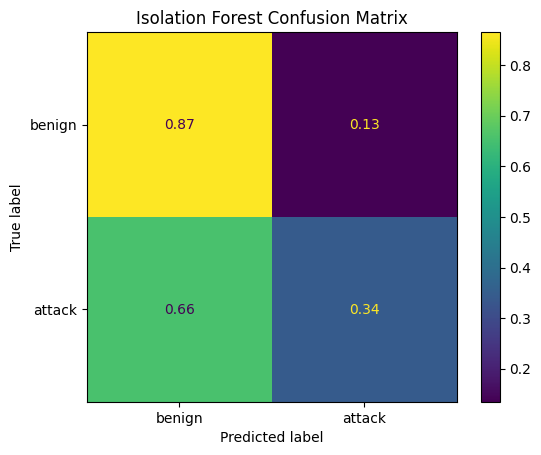

In [8]:
def confusion_matrix_plot(y_true, y_pred, title):
  cm = confusion_matrix(y_true, y_pred, normalize='true')
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign', 'attack'])
  disp.plot()
  plt.title(title)
  plt.show()

confusion_matrix_plot(full_df['if_outliers'], full_df['Label'], 'Isolation Forest Confusion Matrix')

From the results, we can see that the Isolation Forest algorithm is not much sensitive nor precise when detecting outliers.

In [9]:
full_df.to_csv('./data/clean_swat.csv')

## Outlier detection with LocalOutlierFactor

In [10]:
local_factor_outliers_indices = get_list_of_lof_outliers(full_df.drop(columns=['Date', 'Attack', 'Label']), outlier_fraction)

lof_outliers = np.zeros(len(full_df))
lof_outliers[local_factor_outliers_indices] = 1
full_df['lof_outliers'] = lof_outliers

In [11]:
attack_lof_outliers = full_df[(full_df['lof_outliers'] == 1) & (full_df['Label'] == 1)]
lof_outliers_matches = len(attack_lof_outliers)
print(f'{lof_outliers_matches} outliers found with Local Outlier Factor are labeled as attacks')

606 outliers found with Local Outlier Factor are labeled as attacks


In [12]:
print(classification_report(full_df['lof_outliers'], full_df['Label']))

              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84     12443
         1.0       0.24      0.24      0.24      2553

    accuracy                           0.74     14996
   macro avg       0.54      0.54      0.54     14996
weighted avg       0.74      0.74      0.74     14996



Now we display the confusion matrix.

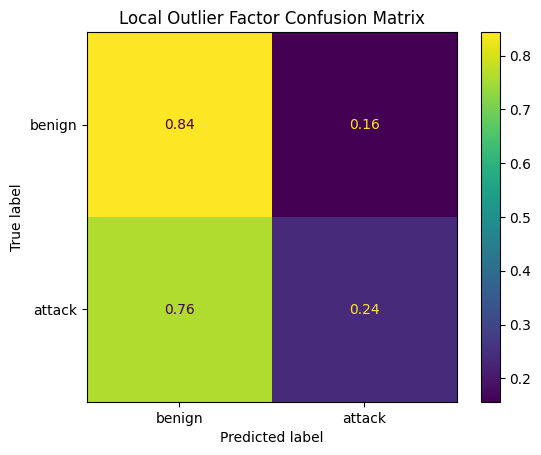

In [13]:
confusion_matrix_plot(full_df['lof_outliers'], full_df['Label'], 'Local Outlier Factor Confusion Matrix')

In comparison, as we can see from this report, LocalOutlierFactor algorithm is even less sensitive than the Isolation Forest algorithm.\
We can assume that an unsupervised algorithm may not be the best choice for this dataset.

## Classification

### Data preparation

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, TimeSeriesSplit
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [15]:
seed: int = 42
one_hot_encoded_df = get_one_hot_encoded_dataframe(full_df.drop(columns=['Date', 'Attack', 'Label']))
no_nan_df = remove_nan_through_mean_imputation(one_hot_encoded_df)

### Random Forest Classifier

In [16]:
def gen_random_forest() -> RandomForestClassifier:
    return RandomForestClassifier(
        n_estimators=128,
        max_depth=9,
        max_features='sqrt',
        random_state=seed
    )

def cross_validate_model(X, y, model_gen, model_name, tscv) -> pd.DataFrame:
    res_total = pd.DataFrame()
    for (train_index, test_index) in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = model_gen()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        res = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True, zero_division=0))
        res_total = pd.concat([res_total, res[['weighted avg']]], axis=1)

    res_total = res_total.mean(axis=1).to_frame().T.drop(columns=['support'])
    res_total.index = [model_name]
    return res_total

In [17]:
X = no_nan_df.to_numpy()
y = full_df['Label'].to_numpy()

n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=int(0.5 * X.shape[0] // n_splits))

cross_validate_model(X, y, gen_random_forest, 'Random Forest', tscv)

,precision,recall,f1-score
Random Forest,0.529652,0.65893,0.568958


We plot the confusion matrix.

In [18]:
# confusion_matrix_plot(y_test, y_pred, 'Random Forest Confusion Matrix')

### Decision Tree Classifier

In [19]:
decision_tree = DecisionTreeClassifier(
    max_depth=128,
    max_leaf_nodes=256,
    max_features='sqrt',
    random_state=seed
)

# decision_tree.fit(X_train, y_train)

# y_pred = decision_tree.predict(X_test)
# print(classification_report(y_test, y_pred))

In [20]:
# confusion_matrix_plot(y_test, y_pred, 'Decision Tree Confusion Matrix')

### XGBoost Classifier

In [21]:
def gen_XGBoostClassifier() -> XGBClassifier:
    return XGBClassifier(
        n_estimators=128,
        max_depth=7,
        learning_rate=1e-2,
        random_state=seed
    )

cross_validate_model(X, y, gen_XGBoostClassifier, 'XGBoost', tscv)

,precision,recall,f1-score
XGBoost,0.747405,0.793251,0.760983


In [22]:
# confusion_matrix_plot(y_test, y_pred, 'XGBoost Classifier Confusion Matrix')

### Multi-layer Perceptron Classifier

In [23]:
mlp = MLPClassifier(
    hidden_layer_sizes=(256, 256),
    batch_size=32,
    learning_rate='adaptive',
    random_state=42,
    early_stopping=True
)

# mlp.fit(X_train, y_train)

# y_pred = mlp.predict(X_test)
# print(classification_report(y_test, y_pred))

In [24]:
# confusion_matrix_plot(y_test, y_pred, 'Multi-Layer Perceptron Confusion Matrix')